In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import torch.nn as nn
import triton
import original_quant
import quant
import json
from matplotlib import pyplot as plt
import numpy as np
from fused_mlp import llama_mlp_fused_4_kernel
from transformers.models.llama.modeling_llama import LlamaMLP
from quant_linear import matmul4_kernel

## Benchmark QuantLinear Kernel
Tests the speed of the Triton, CUDA, and FP16 kernels on 4096x4096, 4096x11008, 11008x4096, and 4096x12288 matrices.

4096->4096


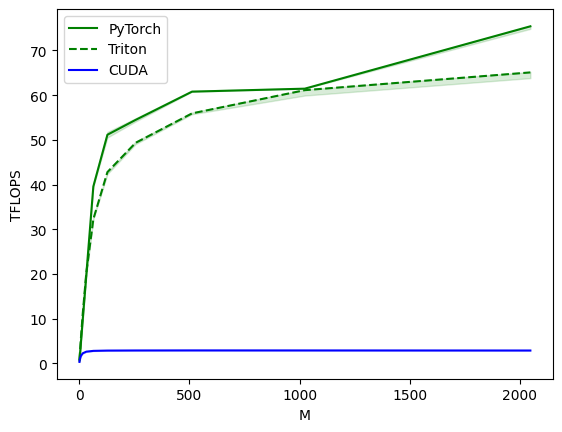

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.655360   0.744727  0.352344
1      2.0   1.236528   1.489455  0.682667
2      4.0   2.473057   2.978909  1.139756
3      8.0   4.946113   5.825422  1.724632
4     16.0   9.892226  11.155064  2.269645
5     32.0  19.784453  20.164923  2.634613
6     64.0  39.568906  32.263877  2.811196
7    128.0  51.150050  42.799022  2.876752
8    256.0  54.471483  49.344753  2.901629
9    512.0  60.787013  55.924051  2.916509
10  1024.0  61.455001  61.119185  2.909680
11  2048.0  75.403216  65.091039  2.892810


4096->11008


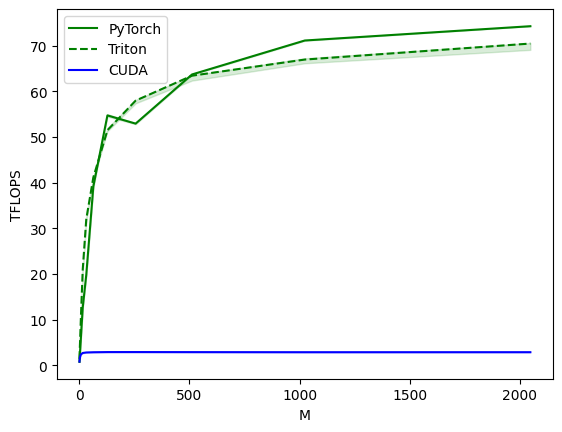

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.752684   1.420387  0.823028
1      2.0   1.601164   2.795683  1.324271
2      4.0   3.202327   5.591365  1.914435
3      8.0   6.404654  11.008000  2.412712
4     16.0  12.693910  21.030209  2.704461
5     32.0  19.845408  32.023272  2.813827
6     64.0  39.139554  41.139388  2.865326
7    128.0  54.719379  51.471198  2.902212
8    256.0  52.921088  57.954716  2.905578
9    512.0  63.684703  63.415989  2.892160
10  1024.0  71.117931  66.946945  2.873360
11  2048.0  74.250747  70.451202  2.877302


11008->4096


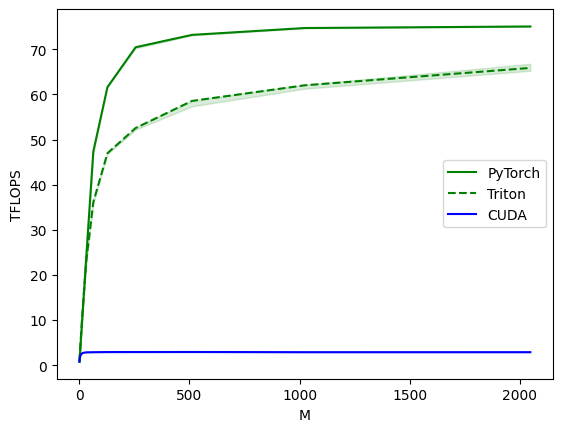

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.721836   0.898612  0.807927
1      2.0   1.505367   1.743842  1.334303
2      4.0   3.010735   3.453490  1.904087
3      8.0   6.021470   6.646340  2.404478
4     16.0  12.042940  12.693910  2.709662
5     32.0  24.085880  23.098755  2.843641
6     64.0  47.362153  36.128822  2.871164
7    128.0  61.596679  46.967468  2.902212
8    256.0  70.451202  52.551011  2.907077
9    512.0  73.196055  58.556843  2.918461
10  1024.0  74.712126  62.020313  2.874643
11  2048.0  75.054132  65.871103  2.878129


4096->12288


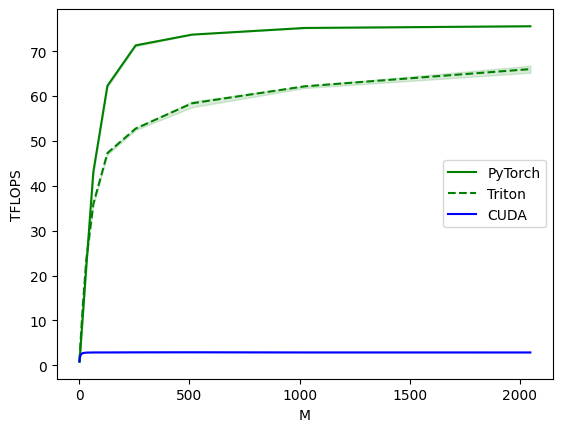

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.768000   0.910222  0.901872
1      2.0   1.374881   1.787345  1.424696
2      4.0   2.769127   3.510857  1.985939
3      8.0   5.499525   6.779586  2.480858
4     16.0  10.922666  13.107200  2.740181
5     32.0  21.998098  23.475582  2.846813
6     64.0  43.092163  35.951178  2.883344
7    128.0  62.291645  47.304183  2.885989
8    256.0  71.291284  52.758542  2.909344
9    512.0  73.692015  58.389384  2.923709
10  1024.0  75.177968  62.176218  2.884748
11  2048.0  75.558866  66.008720  2.880992


In [2]:
matmul4_kernel.record_detailed_timings = True


def benchmarker(M, N, K, provider):
	layer = nn.Linear(K, N)
	vec = torch.randn(M, K, device='cuda', dtype=torch.float16)

	quantizer = original_quant.Quantizer()
	quantizer.configure(4, perchannel=True, sym=False, mse=False)
	quantizer.find_params(layer.weight.data, weight=True)
	layer.weight.data = original_quant.quantize(layer.weight.data, quantizer.scale, quantizer.zero, quantizer.maxq)

	cuda_layer = original_quant.QuantLinear(4, -1, layer.in_features, layer.out_features)
	cuda_layer.pack(layer, quantizer.scale, quantizer.zero)

	# Convert layer to 16-bit
	layer = layer.half()

	# Convert cuda_layer to Triton
	state_dict = cuda_layer.state_dict()
	state_dict['scales'] = state_dict['scales'].to(torch.float16, copy=True)
	state_dict['bias'] = state_dict['bias'].to(torch.float16, copy=True)
	triton_layer = quant.QuantLinear(4, -1, layer.in_features, layer.out_features)
	triton_layer.load_state_dict(state_dict)

	# Move to GPU
	layer = layer.to('cuda')
	cuda_layer = cuda_layer.to('cuda')
	triton_layer = triton_layer.to('cuda')

	if provider == 'torch':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: layer(vec))
	elif provider == 'cuda':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: cuda_layer(vec))
	elif provider == 'triton':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_layer(vec))
	
	perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
	return perf(ms), perf(max_ms), perf(min_ms)


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, 4096, provider)

print("4096->4096")
benchmark.run(show_plots=True, print_data=True)
print()
print()


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 11008, 4096, provider)

print("4096->11008")
benchmark.run(show_plots=True, print_data=True)
print()
print()


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, 11008, provider)

print("11008->4096")
benchmark.run(show_plots=True, print_data=True)
print()
print()


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, 12288, provider)

print("4096->12288")
benchmark.run(show_plots=True, print_data=True)

## Benchmark In-Situ
Benchmark Triton and CUDA kernels in the model itself. This is useful because sometimes the Triton kernel is faster in isolation, but performs worse within the context of the model.

In [3]:
# Load the models
cuda_model = original_quant.load_cuda_quant('../weights/HF/llama-7b', '../GPTQ-for-LLaMa/llama7b-4bit-128g-2.pt', 4, -1)
cuda_model.eval()
cuda_model = cuda_model.to('cuda')

model = quant.load_quant('../weights/llama-7b-4bit', fuse_mlp=False)
model.eval()
model = model.to('cuda')

Loading model ...
Done.
Loading model ...
QuantLinear Warmup: Found 4 unique KN values.
FusedMLP Warmup: Found 0 unique K values.
Warming up autotune cache ...


100%|██████████| 12/12 [00:12<00:00,  1.05s/it]

Done.


Lower is better


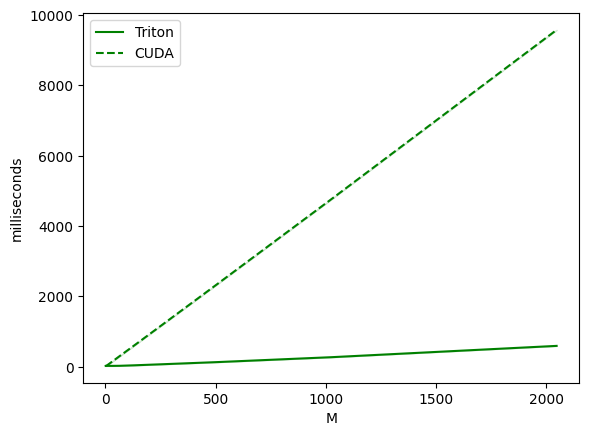

matmul:
         M      Triton         CUDA
0      1.0   21.535744    24.215551
1      2.0   22.529024    24.144896
2      4.0   21.797888    24.033279
3      8.0   22.974464    41.337345
4     16.0   22.086657    77.825027
5     32.0   21.994495   150.831100
6     64.0   24.345600   299.191284
7    128.0   37.688831   591.938599
8    256.0   68.251137  1183.349854
9    512.0  130.852859  2369.772461
10  1024.0  268.648438  4756.672852
11  2048.0  590.846436  9577.994141




In [4]:
def benchmarker(M, K, provider):
	vec = torch.randn(1, M, K, device='cuda', dtype=torch.float16)

	def runfoo(inputs_embeds, model):
		attention_mask = torch.ones(
			(1, M), dtype=torch.bool, device=inputs_embeds.device
		)
		attention_mask = model.model._prepare_decoder_attention_mask(
			attention_mask, (1, M), inputs_embeds, 0
		)

		hidden_states = inputs_embeds

		for idx, decoder_layer in enumerate(model.model.layers):
			layer_outputs = decoder_layer(
				hidden_states,
				attention_mask=attention_mask,
				past_key_value=None,
				output_attentions=False,
				use_cache=False,
			)

			hidden_states = layer_outputs[0]
		
		return hidden_states

	if provider == 'torch':
		raise NotImplementedError
	elif provider == 'cuda':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, cuda_model), rep=10000)
	elif provider == 'triton':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, model), rep=10000)

	return ms, max_ms, min_ms


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['triton', 'cuda'],
		line_names=['Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='milliseconds',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, provider)

print("Lower is better")
benchmark.run(show_plots=True, print_data=True)
print()
print()

## Visualize `benchmark_generate.py` Results
Run `benchmark_generate.py` and save the results to `results-triton.jsonl` and `results-cuda.jsonl`.  Then run this cell to visualize the results.

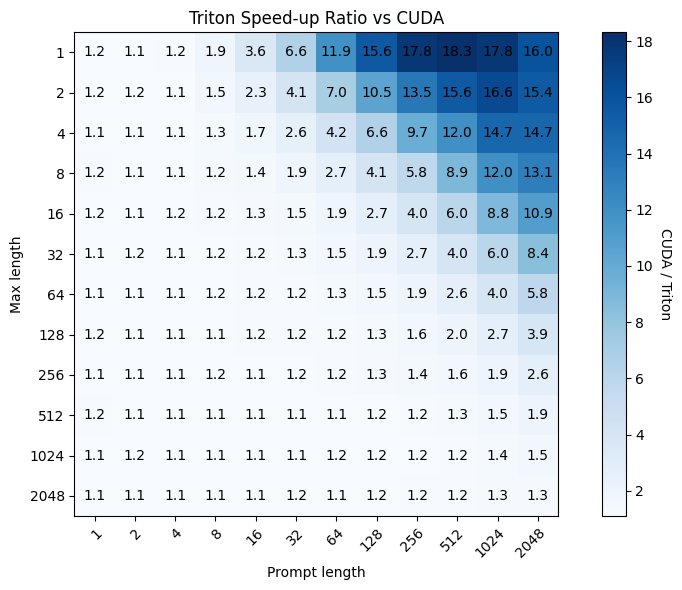

Minimum speed-up: 110.5%
Maximum speed-up: 1831.3%


In [5]:
def read_results(filename):
	with open(filename, 'r') as f:
		results = [json.loads(line) for line in f]
		results = sorted(results, key=lambda x: (x['prompt_length'], x['max_length']))
	return results


# Read the results
triton_results = read_results('results-triton.jsonl')
cuda_results = read_results('results-cuda.jsonl')

# Results as a 2D heatmap
x = sorted(list(set(a['prompt_length'] for a in triton_results)))
y = sorted(list(set(a['max_length'] for a in triton_results)))

z1 = lambda x, y: next(a for a in triton_results if a['prompt_length'] == x and a['max_length'] == y)['average_time']
z2 = lambda x, y: next(a for a in cuda_results if a['prompt_length'] == x and a['max_length'] == y)['average_time']
z = lambda x, y: z2(x, y) / z1(x, y)

# Draw a heatmap with numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
im = ax.imshow([[z(i, j) for i in x] for j in y], cmap='Blues')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('CUDA / Triton', rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(x)), labels=x)
ax.set_yticks(np.arange(len(y)), labels=y)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(x)):
	for j in range(len(y)):
		text = ax.text(i, j, f'{z(x[i], y[j]):.1f}', ha="center", va="center", color="black")

# Label axes
ax.set_xlabel('Prompt length')
ax.set_ylabel('Max length')

ax.set_title("Triton Speed-up Ratio vs CUDA")
f.tight_layout()
plt.show()

# Print some stats
print(f"Minimum speed-up: {(min(z(i, j) for i in x for j in y) * 100):.1f}%")
print(f"Maximum speed-up: {(max(z(i, j) for i in x for j in y) * 100):.1f}%")

## Benchmark Fused MLP Kernel

Lower is better


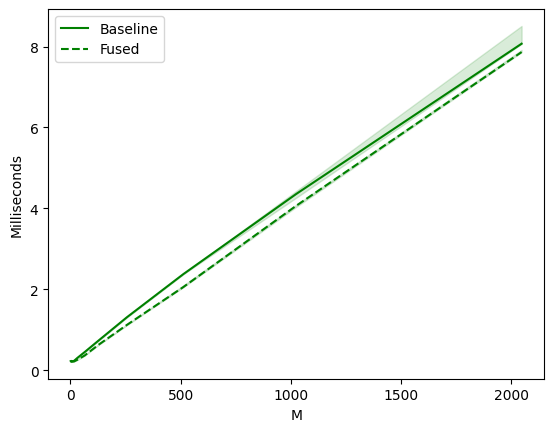

matmul:
         M  Baseline     Fused
0      1.0  0.228352  0.208896
1      2.0  0.230400  0.209920
2      4.0  0.232448  0.214016
3      8.0  0.225280  0.215040
4     16.0  0.233472  0.220160
5     32.0  0.310272  0.263168
6     64.0  0.449536  0.365568
7    128.0  0.738304  0.633856
8    256.0  1.310720  1.121792
9    512.0  2.375680  2.056192
10  1024.0  4.354560  4.063232
11  2048.0  8.070144  7.863296


In [6]:
llama_mlp_fused_4_kernel.record_detailed_timings = True


def benchmarker(M, K, provider):
	vec = torch.randn(1, M, K, device='cuda', dtype=torch.float16)
	layer = LlamaMLP(4096, 11008, 'silu')
	layer = layer.half()

	# Quantize linear layers
	for name, m in layer.named_modules():
		if not isinstance(m, nn.Linear):
			continue

		quantizer = original_quant.Quantizer()
		quantizer.configure(4, perchannel=True, sym=False, mse=False)
		quantizer.find_params(m.weight.data, weight=True)
		m.weight.data = original_quant.quantize(m.weight.data, quantizer.scale, quantizer.zero, quantizer.maxq).to(torch.float16)

		qlayer = original_quant.QuantLinear(4, -1, m.in_features, m.out_features)
		qlayer.pack(m, quantizer.scale, quantizer.zero)
		state_dict = qlayer.state_dict()

		tritonlayer = quant.QuantLinear(4, -1, m.in_features, m.out_features)
		state_dict['scales'] = state_dict['scales'].to(torch.float16, copy=True)
		tritonlayer.load_state_dict(state_dict)
		tritonlayer.bias = None

		setattr(layer, name, tritonlayer)

	# Fuse
	fused_layer = quant.make_fused_mlp(layer)
	assert isinstance(fused_layer, quant.QuantLlamaMLP)

	# Move to CUDA
	layer.to('cuda')
	fused_layer.to('cuda')

	if provider == 'baseline':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: layer(vec))
	elif provider == 'fused':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: fused_layer(vec))
	
	return ms, max_ms, min_ms


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['baseline', 'fused'],
		line_names=['Baseline', 'Fused'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='Milliseconds',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, provider)

print("Lower is better")
benchmark.run(show_plots=True, print_data=True)

## Benchmark Fused MLP In-Situ

In [7]:
# Load the models
fused_model = quant.load_quant('../weights/llama-7b-4bit', fuse_mlp=True)
fused_model.eval()
fused_model = fused_model.to('cuda')

Loading model ...
QuantLinear Warmup: Found 3 unique KN values.
FusedMLP Warmup: Found 1 unique K values.
Warming up autotune cache ...


100%|██████████| 12/12 [00:00<00:00, 3781.49it/s]

Done.


Lower is better


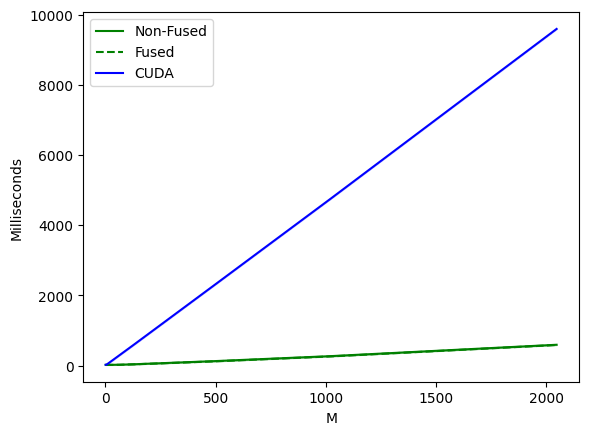

matmul:
         M   Non-Fused       Fused         CUDA
0      1.0   21.269505   18.843649    22.643711
1      2.0   21.624832   19.773952    23.492096
2      4.0   21.616640   19.852287    23.706112
3      8.0   21.604864   19.889153    41.419777
4     16.0   21.740543   19.968000    77.867004
5     32.0   21.827583   20.020224   151.058945
6     64.0   24.736769   22.909952   297.973755
7    128.0   37.696510   35.875839   592.094238
8    256.0   68.491264   64.648193  1186.947510
9    512.0  131.709442  124.966911  2377.593262
10  1024.0  269.758453  262.254578  4766.306641
11  2048.0  593.728516  587.249634  9598.864258




In [8]:
def benchmarker(M, K, provider):
	vec = torch.randn(1, M, K, device='cuda', dtype=torch.float16)

	def runfoo(inputs_embeds, model):
		attention_mask = torch.ones(
			(1, M), dtype=torch.bool, device=inputs_embeds.device
		)
		attention_mask = model.model._prepare_decoder_attention_mask(
			attention_mask, (1, M), inputs_embeds, 0
		)

		hidden_states = inputs_embeds

		for idx, decoder_layer in enumerate(model.model.layers):
			layer_outputs = decoder_layer(
				hidden_states,
				attention_mask=attention_mask,
				past_key_value=None,
				output_attentions=False,
				use_cache=False,
			)

			hidden_states = layer_outputs[0]
		
		return hidden_states

	if provider == 'non-fused':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, model), rep=10000)
	elif provider == 'fused':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, fused_model), rep=10000)
	elif provider == 'cuda':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, cuda_model), rep=10000)

	return ms, max_ms, min_ms


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['non-fused', 'fused', 'cuda'],
		line_names=['Non-Fused', 'Fused', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='Milliseconds',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, provider)

print("Lower is better")
benchmark.run(show_plots=True, print_data=True)
print()
print()

## Detailed Timings
By enabling `record_detailed_timings` on a kernel's autotune, we can get a detailed breakdown of how each configuration performs.  My methodology is to enable all configurations, run the benchmark, and then use the information printed here to select the smallest set of configurations that are useful.

In [9]:
def config_to_str(config):
	kwargs = ', '.join(f"'{k}': {v}" for k,v in config.kwargs.items())
	return f"{{{kwargs}}}, num_stages={config.num_stages}, num_warps={config.num_warps}"

def print_detailed_timings(kernel):
	for k, timing in kernel.detailed_timings.items():
		# Sort timing
		timing = sorted(timing.items(), key=lambda x: x[1][0])
		print(f'{k}:')

		best = timing[0][1][0]

		for config, (ms, min_ms, max_ms) in timing[:4]:
			ratio = ms / best
			if ratio > 1.05:
				break
			print(f'  {config_to_str(config)}: {ratio:.2f}x')
		print()


print("Detailed timings for matmul4_kernel:")
print_detailed_timings(matmul4_kernel)
print()
print("----------------------------------------")
print()

print("Detailed timings for llama_mlp_fused_4_kernel:")
print_detailed_timings(llama_mlp_fused_4_kernel)

Detailed timings for matmul4_kernel:
(1, 4096, 4096):
  {'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(2, 4096, 4096):
  {'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(4, 4096, 4096):
  {'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(8, 4096, 4096):
  {'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(16, 4096, 4096):
  {'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(32, 4096, 4096):
  {'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(64, 4096, 4096):
  {'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(128, 4096, 409